In [5]:
# 使用卷积神经网络识别手写数字
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [6]:
# 定义超参数
image_size=28
num_classes=10
num_epochs=20
batch_size=64

In [7]:
# 1数据集处理
# !wget http://labfile.oss.aliyuncs.com/course/1073/MNIST/data.zip
# !unzip data.zip
train_dataset=dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset=dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

标签是 5


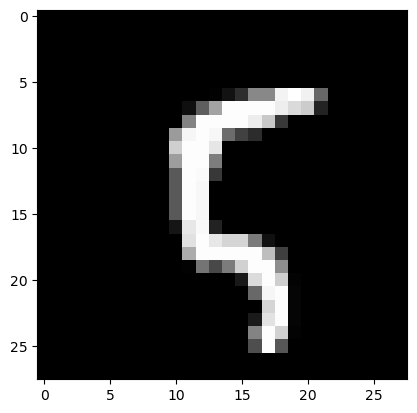

In [8]:
indices=range(len(test_dataset))
indices_val=indices[:5000]
indices_test=indices[5000:]
sampler_val=torch.utils.data.SubsetRandomSampler(indices_val)
sampler_test=torch.utils.data.SubsetRandomSampler(indices_test)

# 校验数据集的加载器
validation_loader=torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    sampler=sampler_val
)
# 验证数据集的加载器
test_loader=torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    sampler=sampler_test
)

idx=100
muteimg=train_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...],cmap='gray')
print('标签是',train_dataset[idx][1])

In [9]:
# 2构建基本的卷积神经网络
# 定义类
depth=[4,8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        # 卷积层1，1输入，4输出，5*5卷积核，padding大小为2保持输出大小
        self.conv1=nn.Conv2d(1,4,5,padding=2)
        # 池化层，2*2池化窗口
        self.pool=nn.MaxPool2d(2,2)
        # 卷积层2，4输入，8输出，5*5卷积核，padding大小为2保持输出大小
        self.conv2=nn.Conv2d(depth[0],depth[1],5,padding=2)
        # 线性层，输入为最后一层卷积后大小，输出512   
        self.fc1=nn.Linear(image_size//4*image_size//4*depth[1],512)
        # 线性层，输入512，输出10个符号的概率
        self.fc2=nn.Linear(512,num_classes)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)

        #将张量铺成一维
        x=x.view(-1,image_size//4*image_size//4*depth[1])
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)#全连接
        x=F.log_softmax(x,dim=1)
        return x
    
    def retrieve_features(self,x):
        feature_map1=F.relu(self.conv1(x))
        x=self.pool(feature_map1)
        feature_map2=F.relu(self.conv2(x))
        return feature_map1,feature_map2



In [10]:
#实例化
net=ConvNet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [11]:
def rightness(predictions,labels):
    pred=torch.max(predictions.data,1)[1]
    rights=pred.eq(labels.data.view_as(pred)).sum()
    return rights,len(labels)

def train_model(data,target):
    net.train()
    output=net(data)
    loss=criterion(output,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    right=rightness(output,target)
    return right,loss

def evaluation_model():
    net.eval()
    val_rights=[]
    for (data,target)in validation_loader:
        data,target=Variable(data),Variable(target)
        output=net(data)
        right=rightness(output,target)
        val_rights.append(right)

    return val_rights


In [12]:
record=[]
weights=[]

for epoch in range(num_epochs):
    train_rights=[]
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=Variable(data),Variable(target)
        right,loss=train_model(data,target)
        train_rights.append(right)
        if batch_idx%100==0:
            val_rights=evaluation_model()
            val_r=(sum([tup[0] for tup in val_rights]),sum([tup[1] for tup in val_rights]))
            train_r=(sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))

            print('训练周期：{}[{}/{}({:.0f}%)]\tLoss:{:.6f}\t训练正确率:{:.2f}%\t校验正确率:{:.2f}%'.format(
                epoch,batch_idx*batch_size,len(train_loader.dataset),
                100.*batch_idx/len(train_loader.dataset),loss.data,
                100.*train_r[0].numpy()/train_r[1],
                100.*val_r[0].numpy()/val_r[1]))
            
            record.append((100-100.*train_r[0]/train_r[1],100-100.*val_r[0]/val_r[1]))

            weights.append(
                [net.conv1.weight.data.clone(),net.conv1.bias.data.clone,
                 net.conv2.weight.data.clone(),net.conv2.bias.data.clone])

训练周期：0[0/60000(0%)]	Loss:2.312382	训练正确率:7.81%	校验正确率:10.20%
训练周期：0[6400/60000(0%)]	Loss:2.295393	训练正确率:10.09%	校验正确率:13.42%
训练周期：0[12800/60000(0%)]	Loss:2.295008	训练正确率:11.74%	校验正确率:11.58%
训练周期：0[19200/60000(0%)]	Loss:2.302743	训练正确率:12.87%	校验正确率:25.68%
训练周期：0[25600/60000(1%)]	Loss:2.278656	训练正确率:14.60%	校验正确率:17.72%
训练周期：0[32000/60000(1%)]	Loss:2.276823	训练正确率:16.25%	校验正确率:36.42%
训练周期：0[38400/60000(1%)]	Loss:2.178660	训练正确率:18.54%	校验正确率:37.48%
训练周期：0[44800/60000(1%)]	Loss:1.961116	训练正确率:21.72%	校验正确率:55.72%
训练周期：0[51200/60000(1%)]	Loss:1.155061	训练正确率:26.58%	校验正确率:71.58%
训练周期：0[57600/60000(2%)]	Loss:0.714355	训练正确率:31.84%	校验正确率:79.98%
训练周期：1[0/60000(0%)]	Loss:0.514713	训练正确率:84.38%	校验正确率:82.26%
训练周期：1[6400/60000(0%)]	Loss:0.665957	训练正确率:82.33%	校验正确率:85.06%
训练周期：1[12800/60000(0%)]	Loss:0.404375	训练正确率:83.83%	校验正确率:86.20%
训练周期：1[19200/60000(0%)]	Loss:0.472677	训练正确率:84.72%	校验正确率:88.28%
训练周期：1[25600/60000(1%)]	Loss:0.279011	训练正确率:85.70%	校验正确率:89.40%
训练周期：1[32000/60000(1%)]	Loss:0.290153	训练正确率:86.33%	

Text(0, 0.5, 'Error rate')

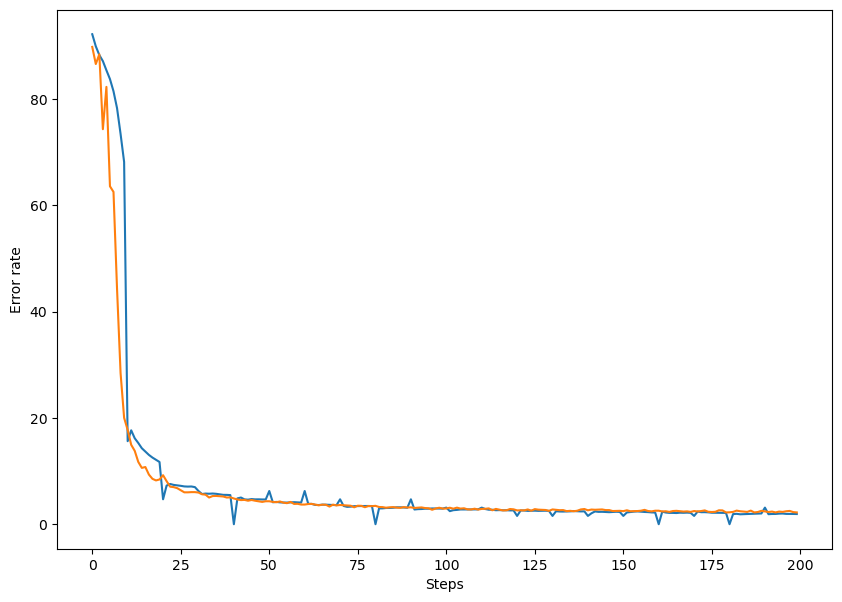

In [13]:
plt.figure(figsize=(10,7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error rate')

In [14]:
net.eval()
vals=[]
for data,target in test_loader:
    data,target=Variable(data,requires_grad=True),Variable(target)
    output=net(data)
    val=rightness(output,target)
    vals.append(val)

rights=(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
rights_rate=1.0*rights[0].data.numpy()/rights[1]
rights_rate

0.9906

正确的标签是： 4
模型预测结果是： [4]


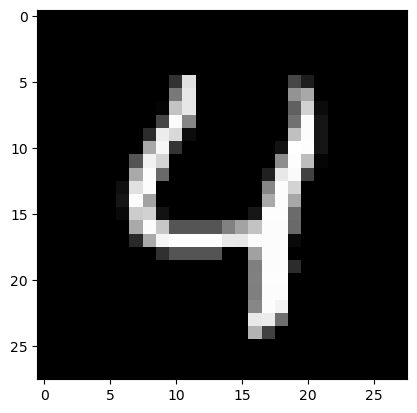

In [15]:
idx=4
muteimg=test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...],cmap='gray')
print('正确的标签是：',test_dataset[idx][1])

test_input=torch.Tensor(muteimg).view(1,1,28,28)
out =net(Variable(test_input))
print('模型预测结果是：',torch.max(out,1)[1].data.numpy())

In [16]:
net.parameters

<bound method Module.parameters of ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=392, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)>

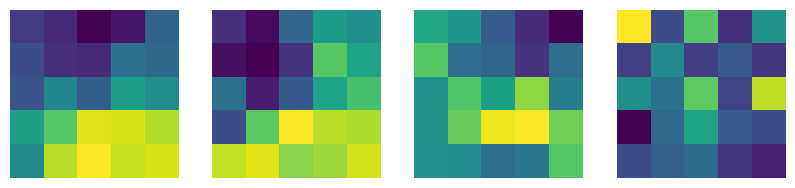

In [17]:
plt.figure(figsize=(10,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])

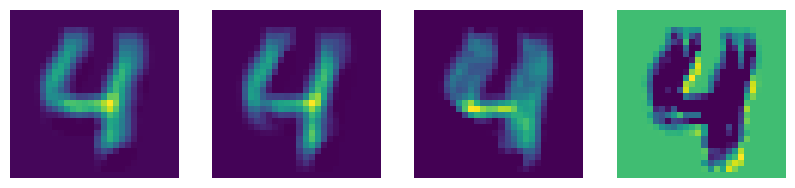

In [18]:
idx=4
input_x=test_dataset[idx][0].unsqueeze(0)
feature_maps=net.retrieve_features(Variable(input_x))
plt.figure(figsize=(10,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0,i,...].data.numpy())

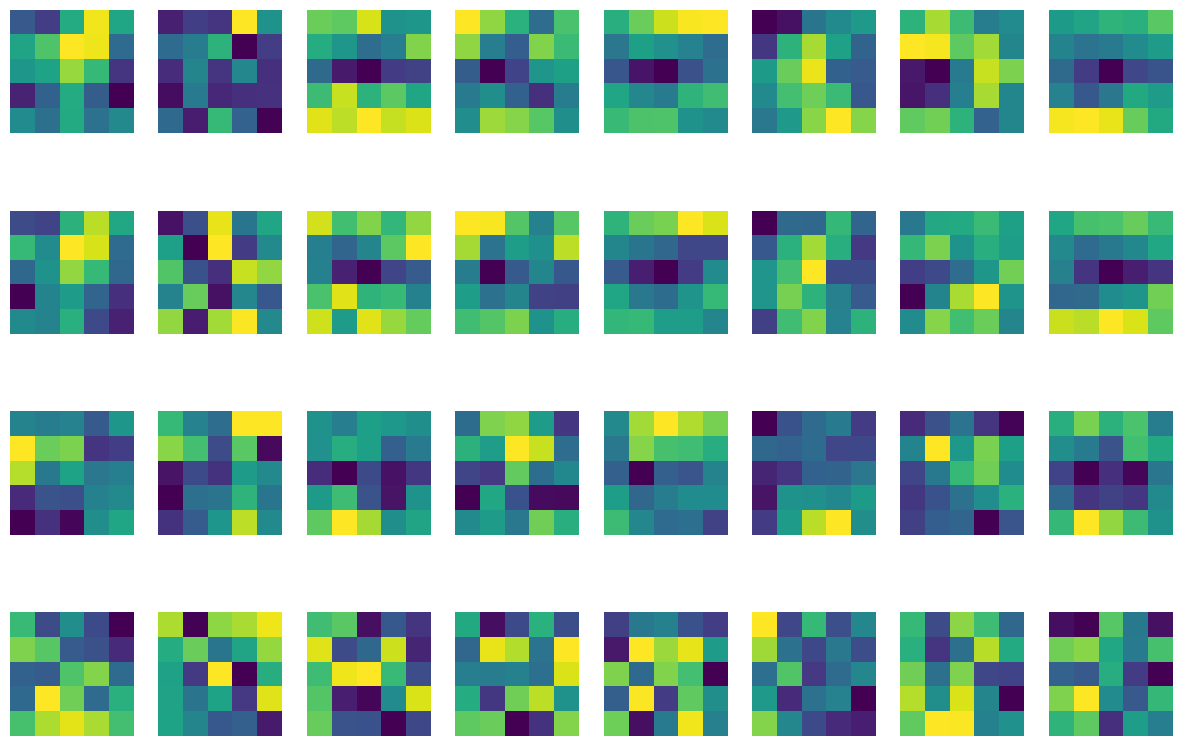

In [22]:
plt.figure(figsize=(15,10))
for i in range(4):
    for j in range(8):
        plt.subplot(4,8,i*8+j+1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j,i,...])

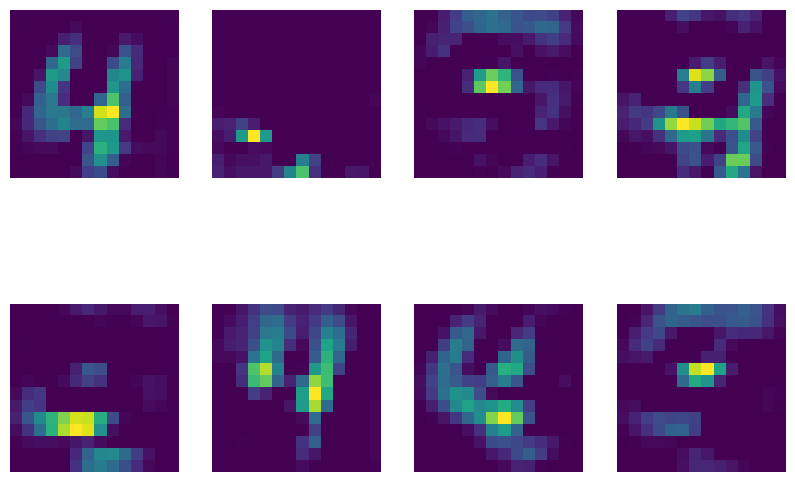

In [20]:
plt.figure(figsize=(10,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0,i,...].data.numpy())

预测结果:  tensor([4])


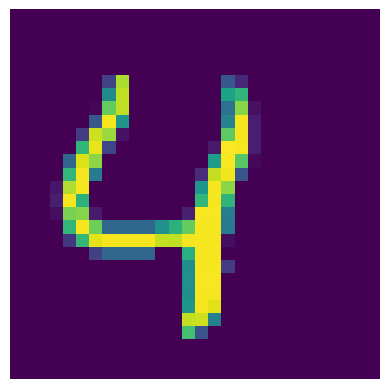

In [23]:
a = test_dataset[idx][0][0]
b = torch.zeros(a.size())
w=3
for i in range(a.size()[0]):
    for j in range(0, a.size()[1]-w):
        b[i,j] = a[i,j+w]

muteimg = b.numpy()
plt.axis('off')
plt.imshow(muteimg)
prediction = net(Variable(b.unsqueeze(0).unsqueeze(0)))
pred = torch.max(prediction.data, 1)[1]
print('预测结果: ', pred)
feature_maps=net.retrieve_features(Variable(b.unsqueeze(0).unsqueeze(0)))

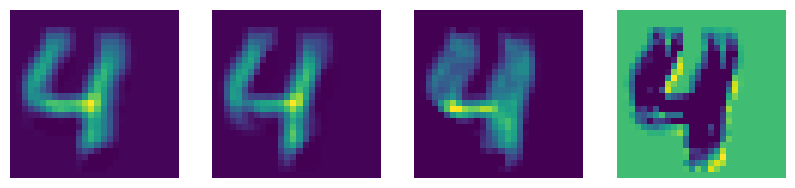

In [26]:
plt.figure(figsize =(10,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0,i,...].data.numpy())

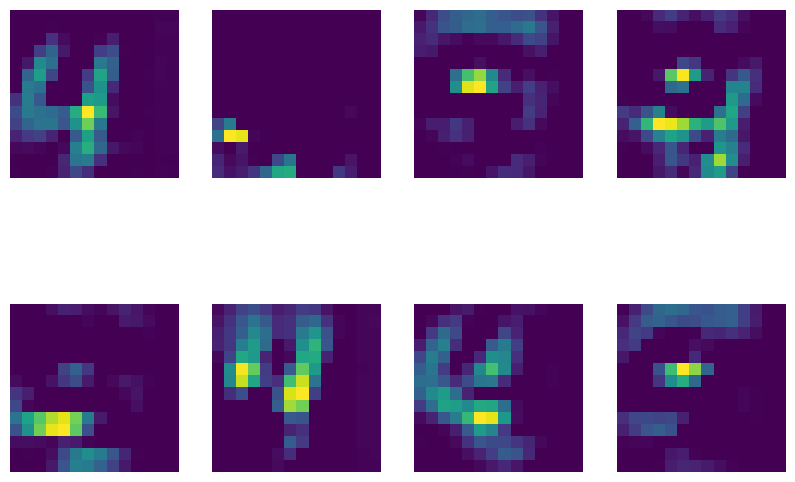

In [27]:
plt.figure(figsize =(10,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis('off')

    plt.imshow(feature_maps[1][0,i,...].data.numpy())